In [138]:
# Hide warnings
from logging import FATAL
import warnings

warnings.filterwarnings('ignore')

# Standard Libraries
import argparse
import json
import time
import networkx as nx
import numpy as np
import concurrent.futures
import mlflow
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pathos.pools as pp

plt.style.use('seaborn')

# Custom Libraries
import qaoa_vrp.build_graph
import qaoa_vrp.features.graph_features
import qaoa_vrp.features.tsp_features
import qaoa_vrp.build_circuit
import qaoa_vrp.clustering
import qaoa_vrp.utils
from qaoa_vrp.exp_utils import str2bool, make_temp_directory
from qaoa_vrp.plot.feasibility_graph import (
    plot_feasibility_results,
    generate_feasibility_results,
)
from qaoa_vrp.initialisation.initialisation import Initialisation
from qaoa_vrp.features.graph_features import get_graph_features
from qaoa_vrp.features.tsp_features import get_tsp_features
from qaoa_vrp.parallel.optimize_qaoa import run_qaoa_parallel_control_max_restarts

# Import Qiskit Dependencies
from qiskit import Aer, QuantumCircuit
from qiskit.circuit import Parameter, ParameterVector
from qiskit.aqua import aqua_globals
from qiskit.aqua.algorithms import NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import NELDER_MEAD, COBYLA
from qiskit.optimization import QuadraticProgram
from qiskit.optimization.algorithms import MinimumEigenOptimizer
from qiskit.optimization.applications.ising.common import sample_most_likely
from qiskit.optimization.applications.ising import tsp
from qiskit.visualization import plot_state_city, plot_histogram

import warnings

warnings.filterwarnings("ignore", category=DeprecationWarning)

In [139]:
filename = "instanceType_asymmetric_tsp_numNodes_4_numVehicles_1_0083a1d22a6447f69091ac552ceb8ee2.json"
instance_path = "../../data/{}".format(filename)

In [140]:
with open(instance_path) as f:
    data = json.load(f)
    G, depot_info = qaoa_vrp.build_graph.build_json_graph(data["graph"])
    num_vehicles = int(data["numVehicles"])
    threshold = float(data["threshold"])
    n_max = int(data["n_max"])

In [141]:
edge_mat = nx.linalg.graphmatrix.adjacency_matrix(G).toarray()
cost_mat = np.array(nx.attr_matrix(G, edge_attr="cost", rc_order=list(G.nodes())))
for edge in G.edges():
    G[edge[0]][edge[1]]['cost'] = 0

edge_mat = nx.linalg.graphmatrix.adjacency_matrix(G).toarray()
cost_mat = np.array(nx.attr_matrix(G, edge_attr="cost", rc_order=list(G.nodes())))

G, cluster_mapping = qaoa_vrp.clustering.create_clusters(
    G, num_vehicles, "spectral-clustering", edge_mat
)

depot_edges = list(G.edges(depot_info["id"], data=True))
depot_node = depot_info["id"]

subgraphs = qaoa_vrp.clustering.build_sub_graphs(G, depot_node, depot_edges)

# big_offset = sum(sum(cost_mat))/2 + 1
big_offset = 30
qubos = qaoa_vrp.build_circuit.build_qubos(subgraphs, depot_info, A=big_offset)

cluster_mapping = [i + 1 for i in cluster_mapping]
cluster_mapping.insert(0, 0)

qubo = qubos[0]
qubos

[\ This file has been generated by DOcplex
 \ ENCODING=ISO-8859-1
 \Problem name: CPLEX
 
 Minimize
  obj: - 120 X11 - 120 X12 - 120 X13 - 120 X21 - 120 X22 - 120 X23 - 120 X31
       - 120 X32 - 120 X33 + [ 120 X11^2 + 120 X11*X12 + 120 X11*X13
       + 120 X11*X21 + 120 X11*X31 + 120 X12^2 + 120 X12*X13 + 120 X12*X22
       + 120 X12*X32 + 120 X13^2 + 120 X13*X23 + 120 X13*X33 + 120 X21^2
       + 120 X21*X22 + 120 X21*X23 + 120 X21*X31 + 120 X22^2 + 120 X22*X23
       + 120 X22*X32 + 120 X23^2 + 120 X23*X33 + 120 X31^2 + 120 X31*X32
       + 120 X31*X33 + 120 X32^2 + 120 X32*X33 + 120 X33^2 ]/2 + 180
 Subject To
 
 Bounds
  0 <= X11 <= 1
  0 <= X12 <= 1
  0 <= X13 <= 1
  0 <= X21 <= 1
  0 <= X22 <= 1
  0 <= X23 <= 1
  0 <= X31 <= 1
  0 <= X32 <= 1
  0 <= X33 <= 1
 
 Binaries
  X11 X12 X13 X21 X22 X23 X31 X32 X33
 End]

## Build New Sample Circuit in `qiskit`

Consider a 2 node TSP. There are two possible paths in the solution:

$A \rightarrow B$ and $B \rightarrow A$. When expressing these paths as bit strings we can represent the paths as `1001` and `0110` respectively.

In the approach explored in this notebook we are trying to reduce the number of feasible paths by constructing a circuit which prevents $|\psi\rangle$ from exploring infeasible solutions.

The approach to do this is as follows:

1. Initialise the circuit in a feasible solution
2. Build quantum circuit for exploring reduced state space
3. Classically optimize circuit angles to end up in a specifc chosen state using the classical cost function

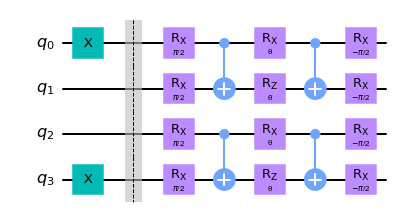

In [207]:
# Create a Quantum Circuit acting on a quantum register of four qubits
num_qubits = 4
fixed_rotation_initial = 0.5*np.pi
fixed_rotation_final = -0.5*np.pi

# Initial params
theta = Parameter('θ')

circ = QuantumCircuit(num_qubits)

# Init circuit in valid state `1001`
circ.x(0)
circ.x(3)
circ.barrier()

# Apply rotation gate
for i in range(num_qubits):
    circ.rx(fixed_rotation, i)

# Apply CNOT gates
circ.cx(0,1)
circ.cx(2,3)

# Apply parameterised X rotation gates 
circ.rx(theta, 0)
circ.rx(theta, 2)

# Apply parameterised Z rotation gates 
circ.rz(theta, 1)
circ.rz(theta, 3)

# Apply CNOT gates
circ.cx(0,1)
circ.cx(2,3)

# Apply rotation gate
for i in range(num_qubits):
    circ.rx(fixed_rotation_final, i)

circ.draw('mpl')

In [208]:
np.random.seed(0)
num_param = 200
theta_guess = [2*np.pi*np.random.uniform() for i in range(num_param)]

In [212]:
THETA_GUESS = 0

In [213]:
trial_circ = circ.assign_parameters({theta:THETA_GUESS})
trial_circ.draw('mpl')
# Run the quantum circuit on a statevector simulator backend
backend = Aer.get_backend('statevector_simulator')
# Create a Quantum Program for execution 
job = backend.run(trial_circ)
result = job.result()
outputstate = result.get_statevector(trial_circ, decimals=3)
counts = result.get_counts()
print(outputstate)

[-0.+0.j -0.-0.j -0.+0.j -0.+0.j -0.+0.j  0.+0.j -0.+0.j -0.+0.j -0.+0.j
  1.+0.j -0.+0.j -0.+0.j -0.+0.j  0.-0.j -0.+0.j -0.+0.j]


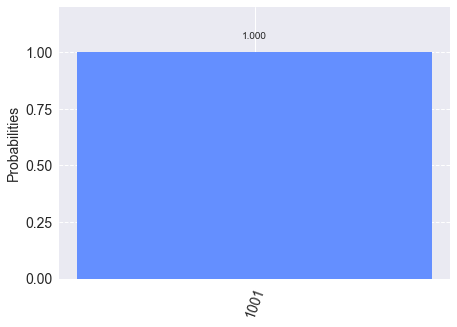

In [214]:
plot_histogram(counts)